In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import datetime
import os

In [2]:
#Hourly Resource Outage Capacity
url = 'http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13103&reportTitle=Hourly%20Resource%20Outage%20Capacity&showHTMLView=&mimicKey'

In [3]:
response = requests.get(url)

In [4]:
soup = bs(response.text, 'html.parser')

In [5]:
title_results = soup.find_all('td', class_='labelOptional_ind')

In [6]:
url_results = soup.find_all('td', class_='labelOptional', text=True)

In [8]:
base_url = 'http://mis.ercot.com'

data_urls = []

for result in url_results:
    try:
        end_url = result.find('div').a['href']
        full_url = base_url + end_url
        data_urls.append(full_url)
        #print(full_url)
    except:
        pass

## Extract Zip File from URL

In [9]:
data = requests.get(data_urls[0], stream=True)

In [10]:
import requests, zipfile, io

z = zipfile.ZipFile(io.BytesIO(data.content))
z.extractall()
file = z.namelist()[0]

print(f'File Name: {file}')

File Name: cdr.00013103.0000000000000000.20200727.220101.HRLYRESOUTCAPNP3233.csv


In [11]:
#load zip file to df
outage_fcst = pd.read_csv(file)

#delete zip file after reading
os.remove(file)

In [12]:
outage_fcst

,Date,HourEnding,TotalResourceMW,TotalIRRMW,TotalNewEquipResourceMW
0,07/27/2020,23,5387,3135,2637
1,07/27/2020,24,4723,3135,2637
2,07/28/2020,1,4723,3135,2637
3,07/28/2020,2,4099,3135,2637
4,07/28/2020,3,4099,3135,2637
...,...,...,...,...,...
163,08/03/2020,18,1286,1358,1922
164,08/03/2020,19,1286,1358,1922
165,08/03/2020,20,1286,1358,1922
166,08/03/2020,21,1286,1358,1922


In [15]:
#clean existing columns
outage_fcst['Date'] = pd.to_datetime(outage_fcst.Date).dt.normalize()

#add file name and process info to df
outage_fcst['FileName'] = z.namelist()[0]
outage_fcst['ProcessDate'] = pd.to_datetime(outage_fcst.FileName.str.split('.').str[3]).dt.normalize()
outage_fcst['ProcessHour'] = outage_fcst.FileName.str.split('.').str[4]
outage_fcst['ProcessDT'] = pd.to_datetime(outage_fcst.FileName.str.split('.').str[3] + outage_fcst.FileName.str.split('.').str[4])
outage_fcst['ProcessHour'] = outage_fcst.ProcessHour.str[0:2]

#change hour ending data type to string
outage_fcst.HourEnding = outage_fcst.HourEnding.astype(str)

#add delivery date time
outage_fcst['DeliveryDT'] = pd.to_datetime(outage_fcst.Date) + outage_fcst.HourEnding.astype('timedelta64[h]')

#add weekday columns
outage_fcst['Weekday'] = outage_fcst.DeliveryDT.dt.day_name().str.upper()

In [17]:
outage_fcst.head()

,Date,HourEnding,TotalResourceMW,TotalIRRMW,TotalNewEquipResourceMW,FileName,ProcessDate,ProcessHour,ProcessDT,DeliveryDT,Weekday
0,2020-07-27,23,5387,3135,2637,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-27 23:00:00,MONDAY
1,2020-07-27,24,4723,3135,2637,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 00:00:00,TUESDAY
2,2020-07-28,1,4723,3135,2637,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 01:00:00,TUESDAY
3,2020-07-28,2,4099,3135,2637,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 02:00:00,TUESDAY
4,2020-07-28,3,4099,3135,2637,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 03:00:00,TUESDAY


In [18]:
outage_fcst.describe()

,TotalResourceMW,TotalIRRMW,TotalNewEquipResourceMW
count,168.000000,168.000000,168.000000
mean,2472.559524,2057.910714,2316.410714
std,1221.724112,627.524152,349.489831
min,1218.000000,1358.000000,1922.000000
25%,1286.000000,1380.000000,1922.000000
50%,2148.000000,2140.000000,2637.000000
75%,3906.000000,2628.000000,2637.000000
max,5387.000000,3135.000000,2637.000000


In [19]:
outage_fcst.dtypes

Date                       datetime64[ns]
HourEnding                         object
TotalResourceMW                     int64
TotalIRRMW                          int64
TotalNewEquipResourceMW             int64
FileName                           object
ProcessDate                datetime64[ns]
ProcessHour                        object
ProcessDT                  datetime64[ns]
DeliveryDT                 datetime64[ns]
Weekday                            object
dtype: object

### Convert DF to Long Format (i.e. Unpivot Forecast columns)

In [23]:
#use pd.melt to unpivot columns
long_outage_fcst = pd.melt(outage_fcst, id_vars=['Date', 'HourEnding', 'FileName', 'ProcessDate', 'ProcessHour', 'ProcessDT', 'DeliveryDT', 'Weekday'],var_name='type', value_name ='mw')

long_outage_fcst.head()

,Date,HourEnding,FileName,ProcessDate,ProcessHour,ProcessDT,DeliveryDT,Weekday,type,mw
0,2020-07-27,23,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-27 23:00:00,MONDAY,TotalResourceMW,5387
1,2020-07-27,24,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 00:00:00,TUESDAY,TotalResourceMW,4723
2,2020-07-28,1,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 01:00:00,TUESDAY,TotalResourceMW,4723
3,2020-07-28,2,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 02:00:00,TUESDAY,TotalResourceMW,4099
4,2020-07-28,3,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 03:00:00,TUESDAY,TotalResourceMW,4099


In [28]:
#modify type columns
long_outage_fcst['type'] = long_outage_fcst.type.str.replace('Total','')
long_outage_fcst['type'] = long_outage_fcst.type.str.replace('MW','')

long_outage_fcst['type'] = long_outage_fcst.type.str.upper()

long_outage_fcst
#long_solar_fcst['Zone'] = long_solar_fcst.solar_zone.str.split('_', n=1).str[1]

,Date,HourEnding,FileName,ProcessDate,ProcessHour,ProcessDT,DeliveryDT,Weekday,type,mw
0,2020-07-27,23,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-27 23:00:00,MONDAY,RESOURCE,5387
1,2020-07-27,24,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 00:00:00,TUESDAY,RESOURCE,4723
2,2020-07-28,1,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 01:00:00,TUESDAY,RESOURCE,4723
3,2020-07-28,2,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 02:00:00,TUESDAY,RESOURCE,4099
4,2020-07-28,3,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-07-28 03:00:00,TUESDAY,RESOURCE,4099
...,...,...,...,...,...,...,...,...,...,...
499,2020-08-03,18,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-08-03 18:00:00,MONDAY,NEWEQUIPRESOURCE,1922
500,2020-08-03,19,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-08-03 19:00:00,MONDAY,NEWEQUIPRESOURCE,1922
501,2020-08-03,20,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-08-03 20:00:00,MONDAY,NEWEQUIPRESOURCE,1922
502,2020-08-03,21,cdr.00013103.0000000000000000.20200727.220101....,2020-07-27,22,2020-07-27 22:01:01,2020-08-03 21:00:00,MONDAY,NEWEQUIPRESOURCE,1922


In [29]:
#rename columns
long_outage_fcst = long_outage_fcst.rename(columns = {'Date':'delivery_date', 'DeliveryDT':'delivery_dt','HourEnding':'delivery_hour', 
                                                  'Weekday':'weekday', 'ProcessDate':'process_date', 'ProcessHour':'process_hour', 'ProcessDT':'process_dt', 'FileName':'file_name'}, inplace=False)
#reorder columns
arranged_columns = ['delivery_dt', 'delivery_date', 'delivery_hour', 'weekday', 'type', 'mw', 'process_date', 'process_hour',
                    'process_dt', 'file_name']

long_outage_fcst = long_outage_fcst[arranged_columns]

long_outage_fcst

,delivery_dt,delivery_date,delivery_hour,weekday,type,mw,process_date,process_hour,process_dt,file_name
0,2020-07-27 23:00:00,2020-07-27,23,MONDAY,RESOURCE,5387,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
1,2020-07-28 00:00:00,2020-07-27,24,TUESDAY,RESOURCE,4723,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
2,2020-07-28 01:00:00,2020-07-28,1,TUESDAY,RESOURCE,4723,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
3,2020-07-28 02:00:00,2020-07-28,2,TUESDAY,RESOURCE,4099,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
4,2020-07-28 03:00:00,2020-07-28,3,TUESDAY,RESOURCE,4099,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
...,...,...,...,...,...,...,...,...,...,...
499,2020-08-03 18:00:00,2020-08-03,18,MONDAY,NEWEQUIPRESOURCE,1922,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
500,2020-08-03 19:00:00,2020-08-03,19,MONDAY,NEWEQUIPRESOURCE,1922,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
501,2020-08-03 20:00:00,2020-08-03,20,MONDAY,NEWEQUIPRESOURCE,1922,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
502,2020-08-03 21:00:00,2020-08-03,21,MONDAY,NEWEQUIPRESOURCE,1922,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....


## Plotting Forecasts

In [31]:
import plotly.express as px

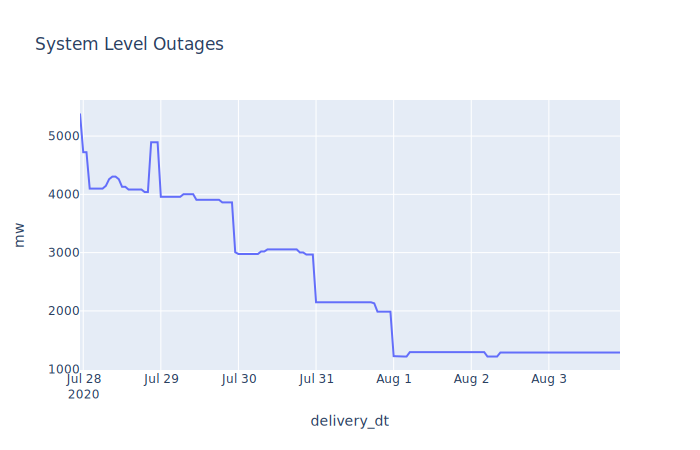

In [32]:
system_df = long_outage_fcst.loc[long_outage_fcst.type == 'RESOURCE', :] 

system_df.head()

systemFig = px.line(system_df, x="delivery_dt", y="mw", title='System Level Outages')

systemFig.show('svg')

## Load Data to PostgreSQL Database

In [35]:
from sqlalchemy import create_engine

In [36]:
connection_string = f"postgres:trumpet5@localhost:5432/ercot_db"
engine = create_engine(f'postgresql://{connection_string}')

In [37]:
#fill table
long_outage_fcst.to_sql(name='da_outage_fcst', con=engine, if_exists='append', index=False)

In [38]:
#Print Table
pd.read_sql_query('select * from da_outage_fcst', con=engine)

,delivery_dt,delivery_date,delivery_hour,weekday,type,mw,process_date,process_hour,process_dt,file_name
0,2020-07-27 23:00:00,2020-07-27,23,MONDAY,RESOURCE,5387,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
1,2020-07-28 00:00:00,2020-07-27,24,TUESDAY,RESOURCE,4723,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
2,2020-07-28 01:00:00,2020-07-28,1,TUESDAY,RESOURCE,4723,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
3,2020-07-28 02:00:00,2020-07-28,2,TUESDAY,RESOURCE,4099,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
4,2020-07-28 03:00:00,2020-07-28,3,TUESDAY,RESOURCE,4099,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
...,...,...,...,...,...,...,...,...,...,...
499,2020-08-03 18:00:00,2020-08-03,18,MONDAY,NEWEQUIPRESOURCE,1922,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
500,2020-08-03 19:00:00,2020-08-03,19,MONDAY,NEWEQUIPRESOURCE,1922,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
501,2020-08-03 20:00:00,2020-08-03,20,MONDAY,NEWEQUIPRESOURCE,1922,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
502,2020-08-03 21:00:00,2020-08-03,21,MONDAY,NEWEQUIPRESOURCE,1922,2020-07-27,22,2020-07-27 22:01:01,cdr.00013103.0000000000000000.20200727.220101....
